# Compute reduced alphabet 

In [1]:
import pandas as pd
import pyrepseq as prs
import numpy as np
import itertools
import matplotlib.pyplot as plt

/home/jhenderson/Documents/Projects/CI_CRUK_2025/venv/lib/python3.12/site-packages/logomaker/../tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import data

In [2]:
DATA_PATH = '/home/jhenderson/Documents/Projects/data_sets/tcr_sequences/CI_CRUK_datathon/'
#DATA_PATH = '/Users/james/Documents/Projects/data_sets/tcr_sequences/CI_CRUK_datathon/'

train = pd.read_csv(DATA_PATH + 'processed_data/train_fixed_lengths.csv')
train = train[['CDR3B', 'epitope', 'Assays']].dropna().reset_index(drop=True)
train = train[train['Assays'].str.contains('mer')]
train['epitope'] = train['epitope'].apply(lambda x: x[2:7])
train['CDR3B'] = train['CDR3B'].apply(lambda x: x[4:14])
aminoacids = 'ACDEFGHIKLMNPQRSTVWY'

## Construct all possible reduced epitopes

In [3]:
letters = ['0', '1']
possible_reduced_epitopes = [''.join(i) for i in itertools.product(letters, repeat = 5)]
reduced_epitope_letter_counts = {epitope : [epitope.count('0'), epitope.count('1')] for epitope in possible_reduced_epitopes}

## Translation evaluation

In [4]:
def translate_df(df, translation, columns_to_translate):
    
    df = df.copy()
    translation_table = str.maketrans(translation)
    for column in columns_to_translate:
        df['translation_'+column] = df[column].apply(lambda x: x.translate(translation_table))
    return df

In [5]:
def compute_epitope_prior(translation):
    
    alphabet = list(translation.values()) 
    counts = {'0':alphabet.count('0'), '1':alphabet.count('1')}
    priors = pd.Series(index=possible_reduced_epitopes)
    for epitope in possible_reduced_epitopes:
        priors[epitope] = ((counts['0']/20)**(reduced_epitope_letter_counts[epitope][0]))*((counts['1']/20)**(reduced_epitope_letter_counts[epitope][1]))
         
    return priors

In [6]:
def pc_conditional(df, feature, grouping, group_weights):
    
    df = df.groupby(grouping).filter(lambda x: len(x) > 1)
    conditional_pcs = df.groupby(grouping).apply(lambda x: prs.pc(x[feature]), include_groups=False)
    adjusted_group_weights = (group_weights**2)/np.sum(group_weights**2)
    
    return np.sum(adjusted_group_weights * conditional_pcs)

In [7]:
def pc_cross(df, feature, grouping, group_weights):
    
    groups = sorted(list(df.groupby(grouping)))
    pc_group = np.sum(group_weights**2)
    data = []
    for ((name1, d1)), (name2, d2) in itertools.combinations(groups, 2):
        pc_cross_group = prs.pc(d1[feature], d2[feature])
        weight = 2*(group_weights[name1] * group_weights[name2]) / (1-pc_group)
        data.append(weight * pc_cross_group)      
    data = np.array(data)
    return np.sum(data)

In [8]:
def estimate_background_pc(df, feature, grouping, epitope_weights):
    
    pc_within = pc_conditional(df, feature, grouping, epitope_weights)
    pc_across = pc_cross(df, feature, grouping, epitope_weights)
    pc_epitope = np.sum(epitope_weights**2)
     
    return pc_epitope*pc_within + (1-pc_epitope)*pc_across

In [9]:
def evaluate_translation(translation, df):
     
    df = translate_df(df, translation, ['CDR3B', 'epitope'])
    epitope_weights = compute_epitope_prior(translation)
        
    background_beta_entropy = -np.log2(estimate_background_pc(df, 'translation_CDR3B', 'translation_epitope', epitope_weights))
    specific_beta_entropy = -np.log2(pc_conditional(df, 'translation_CDR3B', 'translation_epitope', epitope_weights))
     
    return background_beta_entropy - specific_beta_entropy

In [10]:
def make_translation_from_list(aa_to_be_one):
    
    return {aa: '1' if aa in aa_to_be_one else '0' for aa in aminoacids}

In [11]:
def greedy_algorithm(df):
    
    best_amino_acids_to_be_one = []
    best_score = -np.inf
    for i in range(20):
        best_amino_acid_to_be_one = ""
        best_local_score = -np.inf
        for aa in aminoacids:
            if aa not in best_amino_acids_to_be_one:
                list_to_try = best_amino_acids_to_be_one.copy()
                list_to_try.append(aa)
                translation = make_translation_from_list(list_to_try)
                score = evaluate_translation(translation, df)
                
                if score > best_local_score:
                    best_amino_acid_to_be_one = aa
                    best_local_score = score
        
        if best_local_score <= best_score:
            print("Locally optimal set found")
            return best_amino_acids_to_be_one, best_score
        
        print(f"Improvement found, new score: {best_local_score:.1f} bits")
        best_score = best_local_score
        best_amino_acids_to_be_one.append(best_amino_acid_to_be_one)
            
    return best_amino_acids_to_be_one, best_score

## Training the representation

In [12]:
best, score = greedy_algorithm(train)

Improvement found, new score: 0.1 bits
Improvement found, new score: 0.2 bits
Improvement found, new score: 0.4 bits
Improvement found, new score: 0.7 bits
Improvement found, new score: 1.6 bits
Improvement found, new score: 2.5 bits
Improvement found, new score: 2.9 bits
Improvement found, new score: 3.2 bits
Improvement found, new score: 3.4 bits
Locally optimal set found


In [13]:
best, [aa for aa in aminoacids if aa not in best], score

(['R', 'E', 'Q', 'G', 'S', 'Y', 'C', 'K', 'H'],
 ['A', 'D', 'F', 'I', 'L', 'M', 'N', 'P', 'T', 'V', 'W'],
 np.float64(3.437883625079337))

In [14]:
best_translation = make_translation_from_list(best)
translated_df = translate_df(train, best_translation, ['CDR3B', 'epitope'])

In [15]:
translated_df['translation_epitope'].unique().size

32

In [16]:
prs.renyi2_entropy(translated_df, 'translation_CDR3B')

np.float64(8.22344252302389)

In [17]:
prior = compute_epitope_prior(best_translation)
-np.log2(estimate_background_pc(translated_df, 'translation_CDR3B', 'translation_epitope', prior))

np.float64(7.912355721464945)

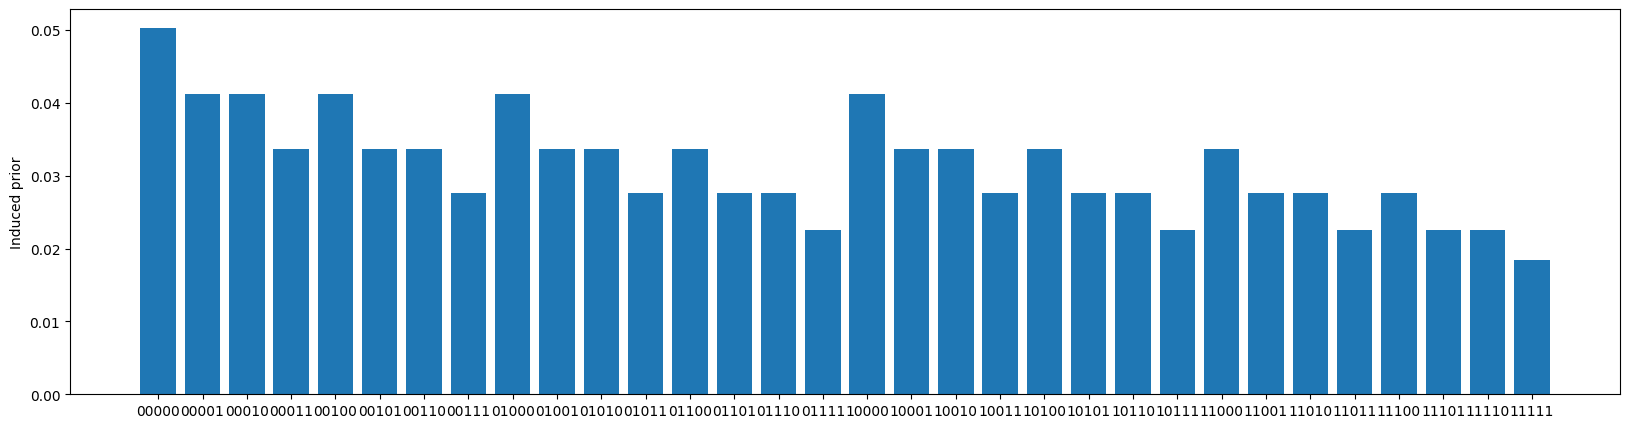

In [18]:
fig, ax = plt.subplots(figsize = (20, 5))
ax.bar(compute_epitope_prior(best_translation).index, compute_epitope_prior(best_translation))
ax.set_ylabel('Induced prior');

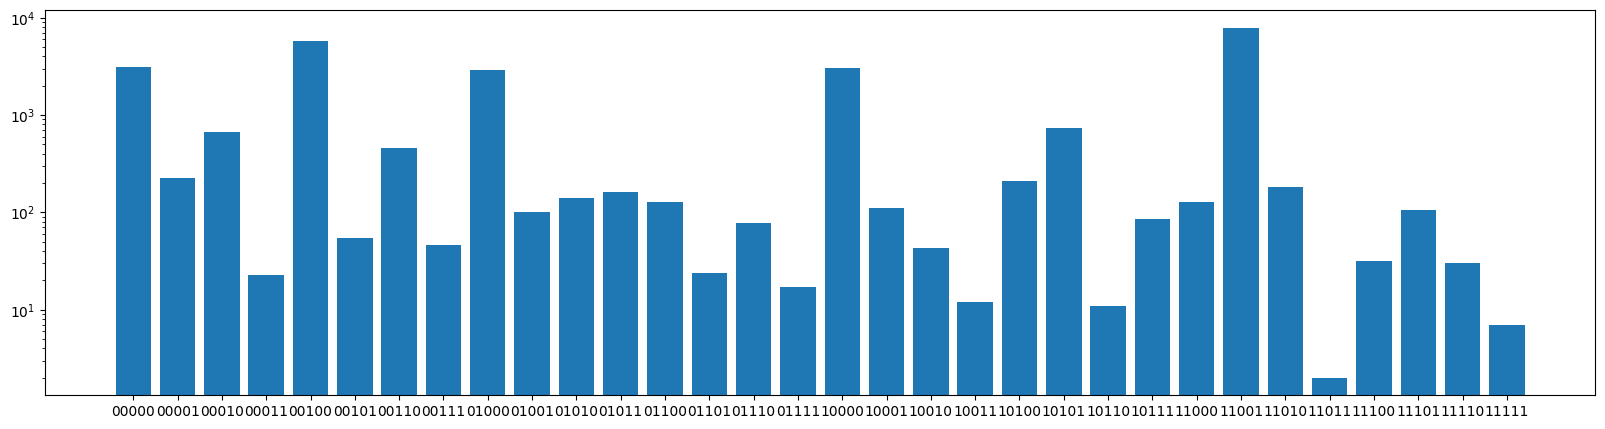

In [19]:
unique_epitopes, counts_epitopes = np.unique(translated_df['translation_epitope'], return_counts=True)
fig, ax = plt.subplots(figsize = (20, 5))
ax.bar(unique_epitopes,counts_epitopes)
ax.set_yscale('log');

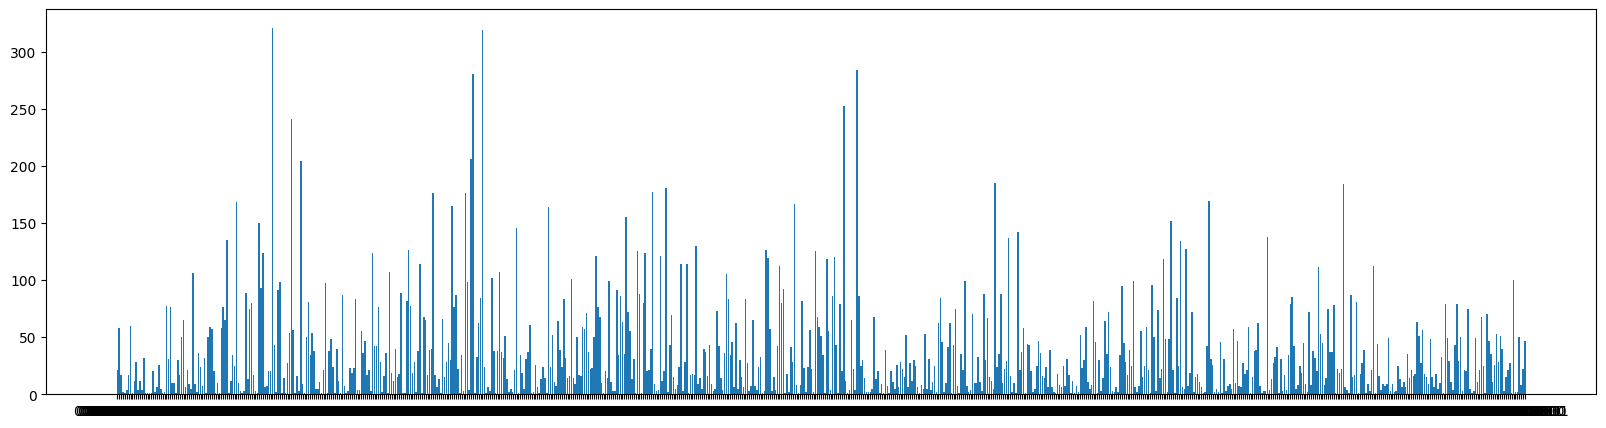

In [20]:
unique_betas, counts_betas = np.unique(translated_df['translation_CDR3B'], return_counts=True)
fig, ax = plt.subplots(figsize = (20, 5))
ax.bar(unique_betas,counts_betas);

## Validation on OLGA

In [23]:
back = pd.read_csv(DATA_PATH + 'raw_data/olga_preprocessed.csv')
back['CDR3B_length'] = back['CDR3B'].apply(lambda x: len(x))
back = back[back['CDR3B_length'] == 15]
back['CDR3B'] = back['CDR3B'].apply(lambda x: x[4:14])
back = translate_df(back, best_translation, ['CDR3B'])

In [24]:
prs.renyi2_entropy(back, 'translation_CDR3B')

np.float64(8.625382333037027)

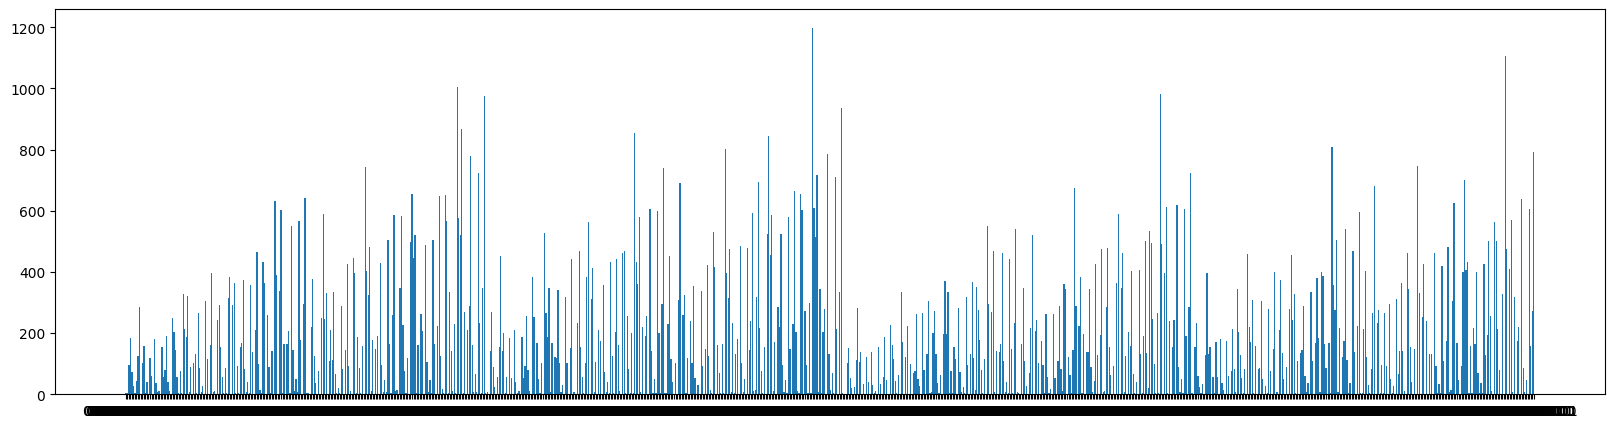

In [25]:
unique_betas, counts_betas = np.unique(back['translation_CDR3B'], return_counts=True)
fig, ax = plt.subplots(figsize = (20, 5))
ax.bar(unique_betas, counts_betas);

## PCA

In [26]:
from sklearn.decomposition import PCA

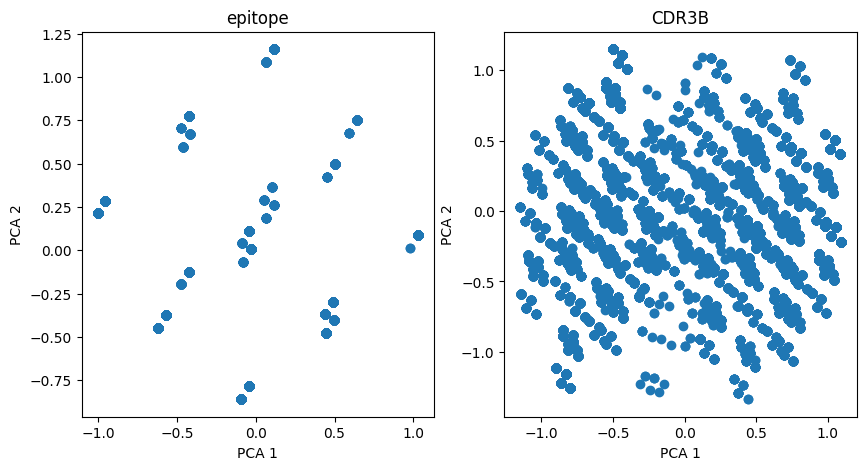

In [27]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

features = ['epitope', 'CDR3B']
for i, feature in enumerate(features):
    X = np.stack(translated_df[f'translation_{feature}'].apply(lambda x: np.array(list(x)).astype(int)).values)
    pca = PCA(n_components=2)
    pca.fit(X) 
    X_r = pca.fit(X).transform(X)
    ax[i].set_title(f"{feature}")
    ax[i].set_xlabel('PCA 1')
    ax[i].set_ylabel('PCA 2')
    ax[i].scatter(X_r[:, 0], X_r[:, 1]);

## Save the data

In [38]:
pd.DataFrame(best_translation, index=['Letter']).to_csv(DATA_PATH + "/reduction_outputs/alphabet.csv")

OSError: Cannot save file into a non-existent directory: '/home/jhenderson/Documents/Projects/data_sets/tcr_sequences/CI_CRUK_datathon/reduction_outputs'

In [30]:
train_to_translate = pd.read_csv(DATA_PATH + 'processed_data/train.csv')
train_to_translate = train_to_translate[['CDR3A', 'CDR3B', 'epitope', 'Assays']].dropna().reset_index(drop=True)
train_to_translate = train_to_translate[~(train_to_translate['CDR3A'].str.contains(r'\#') | (train_to_translate['CDR3A'].str.contains(r'\*')) | (train_to_translate['CDR3A'].str.contains('X')))]

In [31]:
train_to_translate_translated = translate_df(train_to_translate, best_translation, ['CDR3A', 'CDR3B', 'epitope'])

In [32]:
train_to_translate_translated.to_csv(DATA_PATH + "/reduction_outputs/translation_train.csv")

In [33]:
back['translation_vector'] = back['translation_CDR3B'].apply(lambda x: np.array(list(x)).astype(int))
olga_vectors = np.stack(back['translation_vector'].values)
average_vector = olga_vectors.mean(axis=0)
np.savetxt(DATA_PATH + '/reduction_outputs/average_olga_vector.csv', average_vector, delimiter=',')